In [3]:
#!g1.1
tf.__version__

'2.10.1'

In [29]:
!pip install pydot
!pip install pydot-ng
!pip install graphviz 

     ---------------------------------------- 47.0/47.0 kB 1.2 MB/s eta 0:00:00


In [1]:
#!g1.1
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Reshape, Dense, InputLayer, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Subtract, Concatenate, Add
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, Adamax
#from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import graphviz
import pydot_ng as pydot

%matplotlib inline

In [2]:
#test
path_img = './imagenet/imagenet/train/'
images = []
img_size = (256, 256)

i = 0
for filename in os.listdir(path_img):
    images.append(image.load_img(os.path.join(path_img, filename), target_size=img_size, keep_aspect_ratio=True))
    
    i+=1
    if i==2000: break

In [13]:
#!g1.1
def add_noise_and_convert_to_array (input_img, noise_factor=None, norm=True):
    x_images_clear = []
    x_images_noised = []
    for img in input_img:
        if noise_factor == None:
            noise_factor = np.random.uniform(0.1, 0.3)
        img_np = (image.img_to_array(img)) #.astype('float32')
        igm_np = img_np.astype('float32')
        if norm:
            val_upper = 1.
            img_np /= 255.
        else:
            #img_np = img_np.astype('int')
            val_upper = 255.
        x_images_clear.append(img_np)
        noise = noise_factor*val_upper*K.random_normal(img_np.shape, mean=0., stddev=1.0)               
        #noise = np.zeros(img_np.shape)
        #for element in noise:
        #    element = rng.rvs()
        img_noised = img_np + noise
        img_noised = K.clip(img_noised, 0., val_upper)
        x_images_noised.append(img_noised)
    return np.array(x_images_clear), np.array(x_images_noised)

images_clear, images_noised = add_noise_and_convert_to_array(images, norm=True)

In [2]:
#np.save('images_clear', images_clear)
#np.save('images_noised', images_noised)
images_clear = np.load('images_clear.npy')
images_noised = np.load('images_noised.npy')

In [3]:
images_clear.shape

(2000, 256, 256, 3)

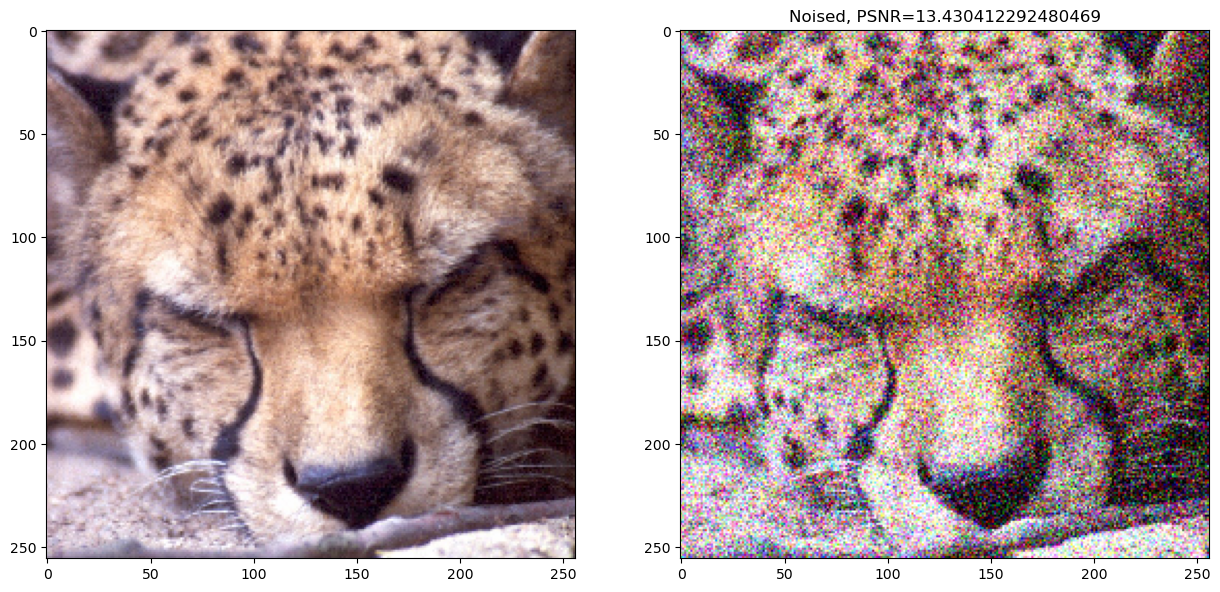

In [3]:
#!g1.1
n=5
max_value=1.
plt.subplots(1,2, figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(image.array_to_img(images_clear[n]))
plt.subplot(1,2,2)
plt.title(f'Noised, PSNR={tf.image.psnr(images_clear[n], images_noised[n], max_val=max_value)}')
plt.imshow(image.array_to_img(images_noised[n]))

In [3]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()

In [4]:
def psnr_loss(y_true, y_pred):
    return 1/tf.image.psnr(y_true, y_pred, max_val=255)

def ssim_loss(y_true, y_pred):
    return 1/tf.image.ssim(y_true, y_pred, max_val=1)

def ssim_l2(y_true, y_pred):
    ssim = 1. - tf.image.ssim(y_true, y_pred, max_val=1.)
    l2 = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return ssim + l2

def wloss(y_true, y_pred):
    return K.mean(y_true*y_pred)

combine_loss = ['mae', ssim_loss]

In [5]:
#!g1.1
def plot_result(image_clear, image_noised, image_reconstructed, max_value=255):
    plt.subplots(1,3, figsize=(15, 15))
    plt.subplot(1,3,1)
    plt.imshow(image_clear)
    #plt.imshow(image.array_to_img(image_clear))
    #plt.imshow(image_clear)
    plt.title(f'Ground True')
    plt.subplot(1,3,2)
    plt.imshow(image_noised)
    plt.title(f'Noised, PSNR={tf.image.psnr(image_clear, image_noised, max_val=max_value)}')
    plt.subplot(1,3,3)
    plt.imshow(image_reconstructed)
    plt.title(f'Reconstructed, PSNR={tf.image.psnr(image_clear, image_reconstructed, max_val=max_value)}')

In [6]:
def calc_mean_image_metrics(images_clear, images_reconstructed, max_value):
    psnrs = []
    ssims = []
    for i in range(images_reconstructed.shape[0]):
        psnr = tf.image.psnr(images_clear[i], images_reconstructed[i], max_val=max_value)
        psnrs.append(psnr)
        ssim = tf.image.ssim(images_clear[i], images_reconstructed[i], max_val=max_value)
        ssims.append(ssim)
    return np.mean(np.array(psnrs)), np.mean(np.array(ssims))

In [7]:
def predict_all(model, x):
    yy = []
    for i in range(x.shape[0]):
        image = x[i][np.newaxis, :]
        y = model.predict(image)
        yy.append(y[0])
    return np.array(yy)

# Autoencoder

In [14]:
#!g1.1
img_shape=(256, 256, 3)

input = Input(img_shape)
encode = Conv2D(256, kernel_size=(3,3),
                bias_initializer='glorot_normal',
                kernel_initializer='glorot_normal',
                padding='same')(input)
encode = BatchNormalization()(encode)
encode = Activation('gelu')(encode)
encode = MaxPooling2D(pool_size=(2,2))(encode)
encode = Conv2D(256, kernel_size=(3,3),
                bias_initializer='glorot_normal',
                kernel_initializer='glorot_normal',
                padding='same')(encode)
encode = BatchNormalization()(encode)
encode = Activation('gelu')(encode)
encode = MaxPooling2D(pool_size=(2,2))(encode)

decode = Conv2DTranspose(256, kernel_size=(3,3),
                         bias_initializer='glorot_normal',
                         kernel_initializer='glorot_normal',
                         strides=2, padding='same')(encode)
decode = BatchNormalization()(decode)
decode = Activation('gelu')(decode)
decode = Conv2DTranspose(256, kernel_size=(3,3),
                         bias_initializer='glorot_normal',
                         kernel_initializer='glorot_normal',
                         strides=2, padding='same')(decode)
decode = BatchNormalization()(decode)
decode = Activation('gelu')(decode)

out = Conv2DTranspose(3, kernel_size=(3,3), activation='sigmoid', padding='same')(decode)

ae = Model(input, out)

ae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 256)     7168      
                                                                 
 batch_normalization_4 (Batc  (None, 256, 256, 256)    1024      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 256, 256, 256)     0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 256)    0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 256)     5900

In [15]:
#!g1.1
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5) #,
                                        #min_lr=1e-10)

ae.compile(optimizer=Adamax(learning_rate=1e-2), loss=ssim_l2)

history = ae.fit(images_noised, images_clear,
                epochs=30,
                #initial_epoch=76,
                callbacks=[reduce_lr],
                validation_split=0.2,
                batch_size=1)

plot_history(history)

Epoch 1/30
1600/1600 [==============================] - 243s 98ms/step - loss: 1.7809 - val_loss: 1.6651 - lr: 0.0100
Epoch 2/30
1600/1600 [==============================] - 142s 89ms/step - loss: 1.5958 - val_loss: 1.5031 - lr: 0.0100
Epoch 3/30
1600/1600 [==============================] - 144s 90ms/step - loss: 1.5352 - val_loss: 1.5249 - lr: 0.0100
Epoch 4/30
1600/1600 [==============================] - 146s 92ms/step - loss: 1.5013 - val_loss: 1.4732 - lr: 0.0100
Epoch 5/30
1600/1600 [==============================] - 154s 97ms/step - loss: 1.4758 - val_loss: 1.4598 - lr: 0.0100
Epoch 6/30
1600/1600 [==============================] - 154s 97ms/step - loss: 1.4609 - val_loss: 1.4693 - lr: 0.0100
Epoch 7/30
1600/1600 [==============================] - 157s 98ms/step - loss: 1.4458 - val_loss: 1.4402 - lr: 0.0100
Epoch 8/30
1600/1600 [==============================] - 157s 98ms/step - loss: 1.4377 - val_loss: 1.4655 - lr: 0.0100
Epoch 9/30
1600/1600 [==============================] - 

KeyboardInterrupt: 

In [34]:
y = predict_all(ae, images_noised)

1/1 [==============================] - 0s 47ms/step


mean PSNR=22.35626220703125
mean SSIM=0.6677693128585815


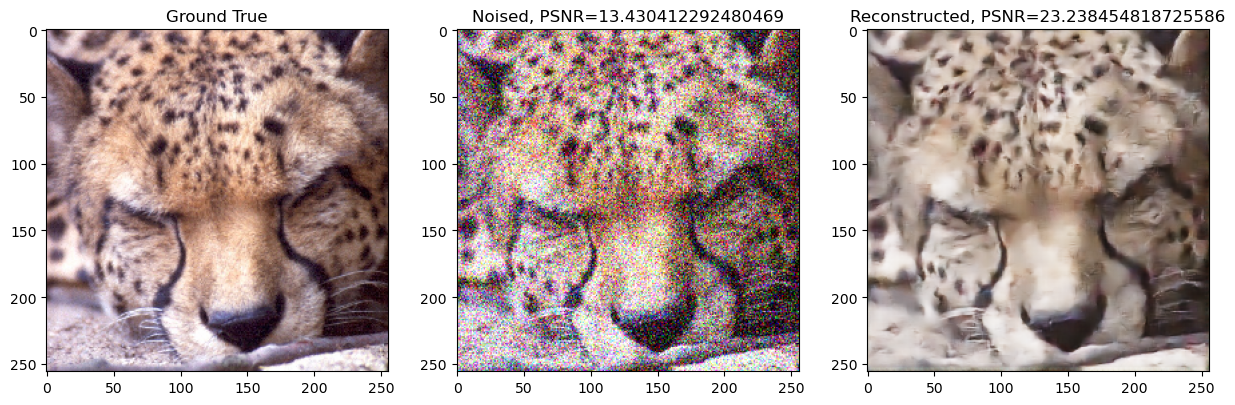

In [35]:
#!g1.1
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

In [43]:
ae_v3.save('ae_v3_adamax_gelu_no_activ_out_no_norm_mae_150_10.39_best')

INFO:tensorflow:Assets written to: ae_v3_adamax_gelu_no_activ_out_no_norm_mae_150_10.39_best\assets


INFO:tensorflow:Assets written to: ae_v3_adamax_gelu_no_activ_out_no_norm_mae_150_10.39_best\assets


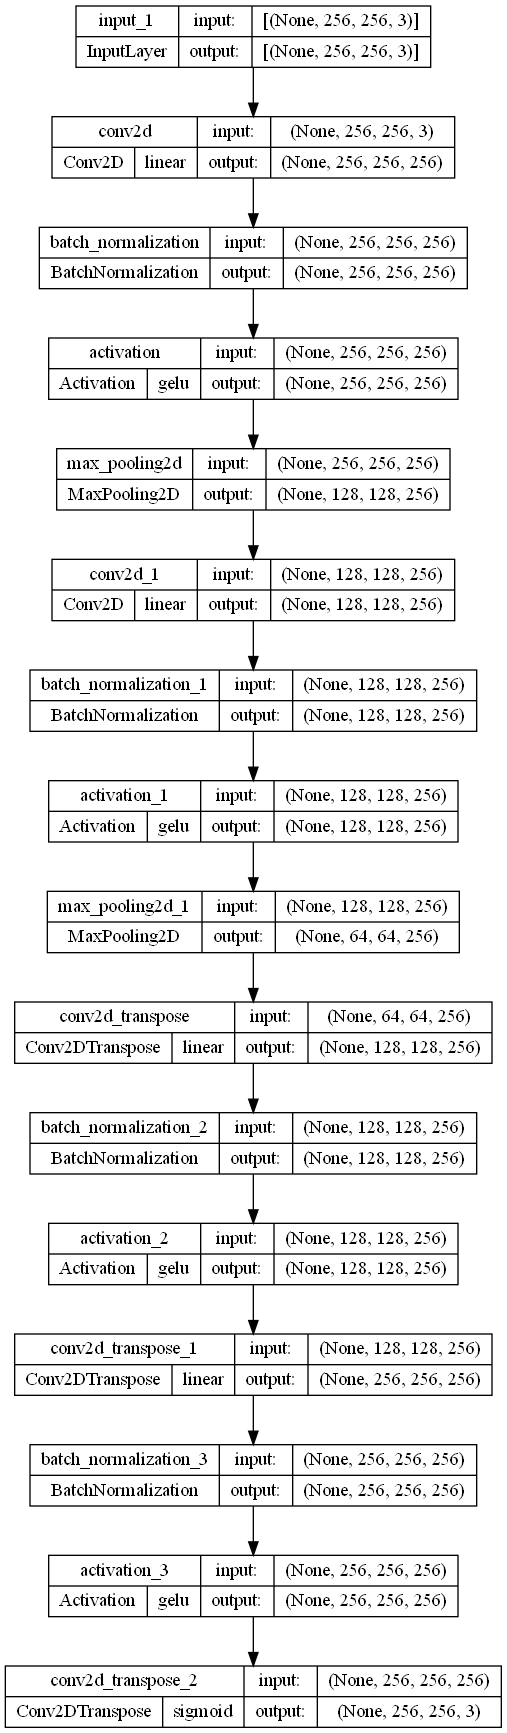

In [5]:
plot_model(ae, show_shapes=True, show_layer_activations=True, to_file='pics/ae.png')

# dnCNN

In [9]:
img_shape=(256, 256, 3)
input = Input(img_shape)
hidden = 16
x = Conv2D(128, kernel_size=(3,3), padding='same')(input)
x = Activation('gelu')(x)
for i in range(hidden):
    x = Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('gelu')(x)
x = Conv2D(3, kernel_size=(3,3), padding='same')(x)
out = Subtract()([input, x])

dncnn = Model(input, out)
dncnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 activation (Activation)        (None, 256, 256, 12  0           ['conv2d[0][0]']                 
                                8)                                                            

In [9]:
def dncnn_res(img_shape):

    input = Input(img_shape)
    hidden = 16
    x = Conv2D(128, kernel_size=(3,3), padding='same')(input)
    x = Activation('gelu')(x)
    for i in range(hidden):
        xx = Conv2D(128, kernel_size=(3,3), padding='same')(x)
        xx = BatchNormalization()(xx)
        xx = Activation('gelu')(xx)
        xx = Add()([x, xx])
        x = xx
    x = Conv2D(3, kernel_size=(3,3), padding='same')(x)
    out = Subtract()([input, x])

    model = Model(input, out)
    model.summary()
    return model
#dncnn = dncnn_res((256,256,3))

In [11]:
dncnn = dncnn_res((256,256,3))
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5) #,
                                        #min_lr=1e-10)

dncnn.compile(optimizer=Adamax(learning_rate=1e-2), loss=ssim_l2)

history = dncnn.fit(images_noised, images_clear,
                epochs=30,
                #initial_epoch=76,
                callbacks=[reduce_lr],
                validation_split=0.2,
                shuffle=True,
                batch_size=1)

plot_history(history)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 256, 256, 12  3584        ['input_2[0][0]']                
                                8)                                                                
                                                                                                  
 activation_17 (Activation)     (None, 256, 256, 12  0           ['conv2d_18[0][0]']              
                                8)                                                          

KeyboardInterrupt: 

In [11]:
y = predict_all(dncnn, images_noised)

1/1 [==============================] - 0s 180ms/step


mean PSNR=21.895164489746094
mean SSIM=0.6157948970794678


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


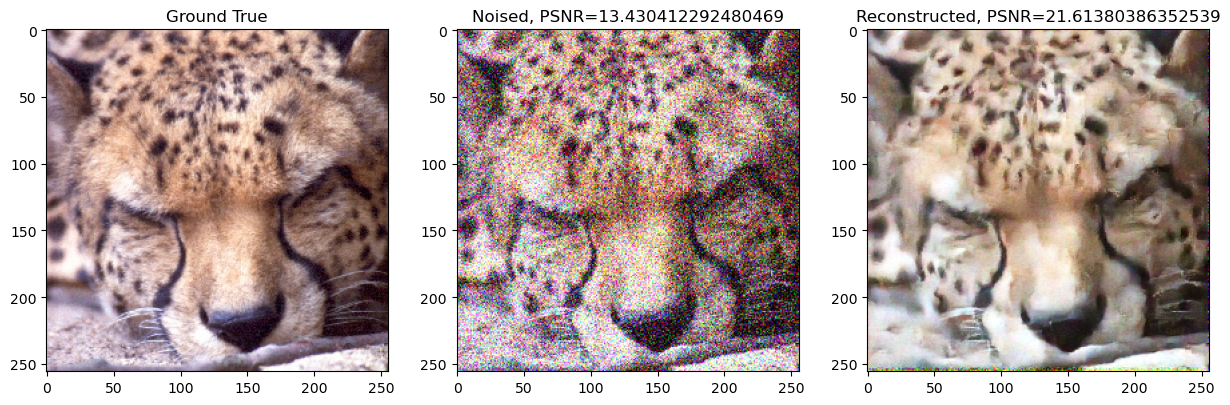

In [12]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

# RAW

In [52]:
!pip install rawpy
!pip install imageio

     -------------------------------------- 793.6/793.6 kB 6.3 MB/s eta 0:00:00


In [70]:
import rawpy
import scipy as sp
import statsmodels


In [75]:
raw = rawpy.imread('raw_noise/high_iso/test_0001.CR3')

(4498, 6742, 3)


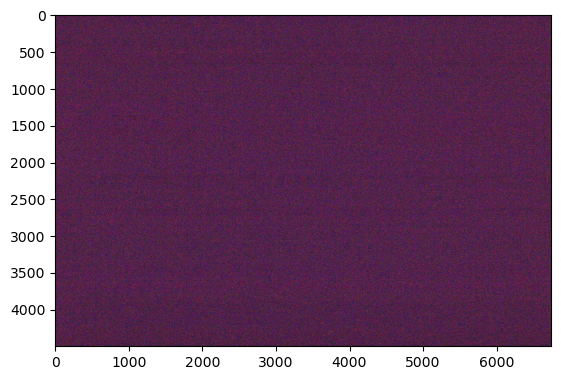

In [76]:
rgb = raw.postprocess(use_camera_wb=True, output_color=rawpy.ColorSpace.sRGB)
print (rgb.shape)
plt.imshow(rgb)

In [77]:
vec=rgb.flatten()

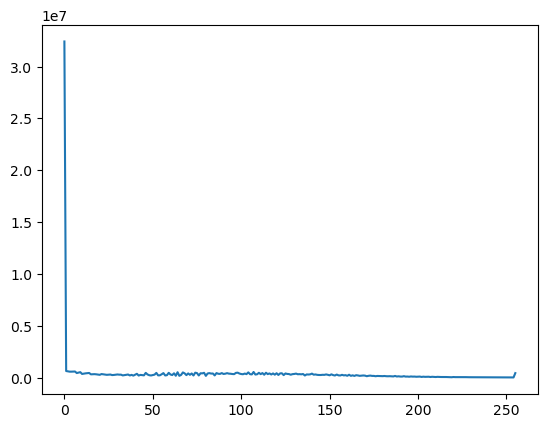

In [79]:
vec_counts = np.unique(vec, return_counts=True)
plt.plot(vec_counts[0], vec_counts[1])

{'whiskers': [<matplotlib.lines.Line2D at 0x1f488d26a30>,
 'caps': [<matplotlib.lines.Line2D at 0x1f488d26fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f488d26760>],
 'medians': [<matplotlib.lines.Line2D at 0x1f488d4e5b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f488d4e880>],
 'means': []}

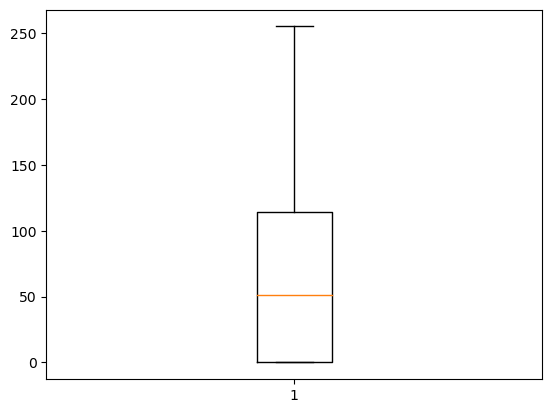

In [73]:
plt.boxplot(vec)

In [80]:
from scipy.stats.sampling import DiscreteGuideTable

In [84]:
vec

array([  0,  99,   0, ...,   0, 106,   0], dtype=uint8)

1.0000000000000004


(array([4540.,  777.,  970., 1016.,  939.,  753.,  461.,  287.,  134.,
         123.]),
 array([  0. ,  24.4,  48.8,  73.2,  97.6, 122. , 146.4, 170.8, 195.2,
        219.6, 244. ]),
 <BarContainer object of 10 artists>)

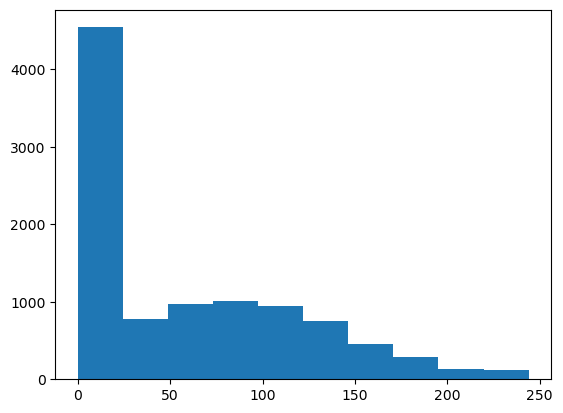

In [85]:
vec_p = vec_counts[1]/len(vec)
print (sum(vec_p))
rng = DiscreteGuideTable(vec_p)

xx = []
for i in range(10000):
    xx.append(rng.rvs())
    
plt.hist(xx)

In [183]:
def noise():
    x = rng.rvs()
    print (x)
    yield x
    
    
x = np.fromiter(noise()) #, dtype=(int, (1,10)))
x

TypeError: fromiter() missing required argument 'dtype' (pos 2)

In [181]:
def cut_image(image):
    subimages = []
    
    
    return subimages

# Unet

In [12]:
def model_unet(img_shape):
    
    input = Input(img_shape)

    conv1_1 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(input)
    conv1_2 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(conv1_1)
    conv1_p = MaxPooling2D(2,2)(conv1_2)
    conv1_bn = BatchNormalization()(conv1_p)

    conv2_1 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(conv1_bn)
    conv2_2 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(conv2_1)
    conv2_p = MaxPooling2D(2,2)(conv2_2)
    conv2_bn = BatchNormalization()(conv2_p)

    conv3_1 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(conv2_bn)
    conv3_2 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(conv3_1)
    conv3_p = MaxPooling2D(2,2)(conv3_2)
    conv3_bn = BatchNormalization()(conv3_p)

    conv4_1 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(conv3_bn)
    conv4_2 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(conv4_1)
    conv4_p = MaxPooling2D(2,2)(conv4_2)
    conv4_bn = BatchNormalization()(conv4_p)

    conv_btnk = Conv2D(1024, kernel_size=(2,2), activation='relu', padding='same')(conv4_bn)
    conv_btnk = Conv2D(1024, kernel_size=(2,2), activation='relu', padding='same')(conv_btnk)

    upconv4_1 = Conv2DTranspose(512, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(conv_btnk)
    upconv4_concat = Add()([upconv4_1, conv4_2])
    upconv4_bn = BatchNormalization()(upconv4_concat)
    upconv4_2 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(upconv4_bn)
    upconv4_3 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(upconv4_2)

    upconv3_1 = Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv4_3)
    upconv3_concat = Add()([upconv3_1, conv3_2])
    upconv3_bn = BatchNormalization()(upconv3_concat)
    upconv3_2 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(upconv3_bn)
    upconv3_3 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(upconv3_2)

    upconv2_1 = Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv3_3)
    upconv2_concat = Add()([upconv2_1, conv2_2])
    upconv2_bn = BatchNormalization()(upconv2_concat)
    upconv2_2 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(upconv2_bn)
    upconv2_3 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(upconv2_2)

    upconv1_1 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv2_3)
    upconv1_concat = Add()([upconv1_1, conv1_2])
    upconv1_bn = BatchNormalization()(upconv1_concat)
    upconv1_2 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(upconv1_bn)
    upconv1_3 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(upconv1_2)

    conv_out = Conv2D(3, kernel_size=(1,1), activation='relu', padding='same')(upconv1_3)
    #out = Add()([input, conv_out])
    out = conv_out

    model = Model(input, out)
    model.summary()
    
    return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 256, 256, 64  832         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_37 (Conv2D)             (None, 256, 256, 64  16448       ['conv2d_36[0][0]']              
                                )                                                           

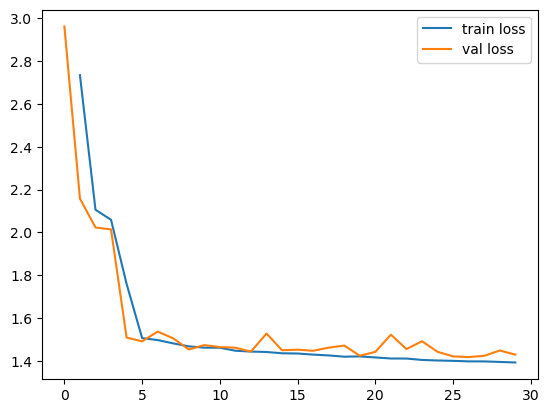

In [13]:
unet = model_unet((256, 256, 3))
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5) #,
                                        #min_lr=1e-10)

unet.compile(optimizer=Adamax(learning_rate=1e-2), loss=ssim_l2)

history = unet.fit(images_noised, images_clear,
                epochs=30,
                callbacks=[reduce_lr],
                validation_split=0.2,
                #huffle=True,
                batch_size=1)

plot_history(history)

In [14]:
y = predict_all(unet, images_noised)

1/1 [==============================] - 0s 53ms/step


mean PSNR=21.322179794311523
mean SSIM=0.6651113629341125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


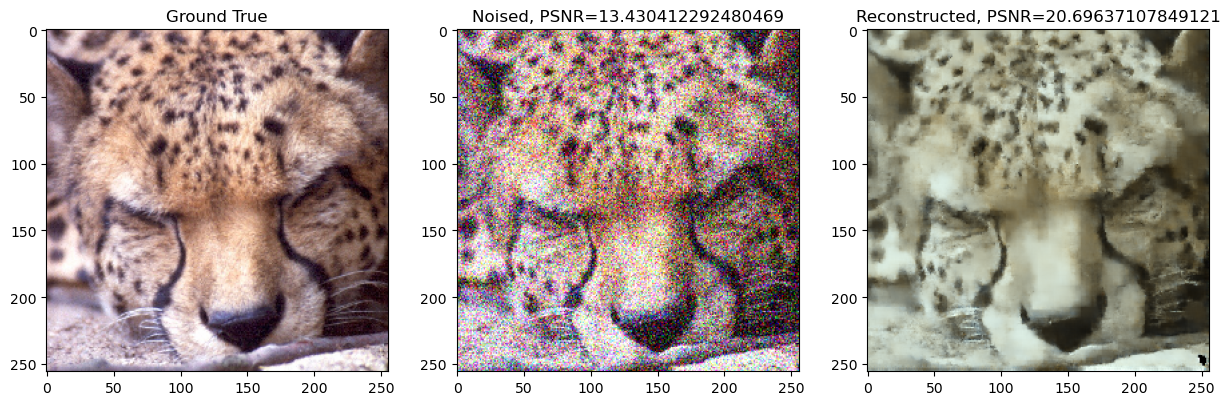

In [15]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

# GAN

In [8]:
def dncnn_res_gan(img_shape):

    input = Input(img_shape)
    hidden = 16
    x = Conv2D(128, kernel_size=(3,3),  bias_initializer='glorot_normal', kernel_initializer='glorot_normal', padding='same')(input)
    x = Activation('gelu')(x)
    for i in range(hidden):
        xx = Conv2D(128, kernel_size=(3,3),  bias_initializer='glorot_normal', kernel_initializer='glorot_normal', padding='same')(x)
        xx = BatchNormalization()(xx)
        xx = Activation('gelu')(xx)
        xx = Add()([x, xx])
        x = xx
    x = Conv2D(3, kernel_size=(3,3),  bias_initializer='glorot_normal', kernel_initializer='glorot_normal', padding='same')(x)
    out = Subtract()([input, x])

    model = Model(input, out)
    model.summary()
    
    return model

In [9]:
def model_unet_gan(img_shape):
    
    input = Input(img_shape)

    conv1_1 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(input)
    conv1_2 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(conv1_1)
    conv1_p = MaxPooling2D(2,2)(conv1_2)
    conv1_bn = BatchNormalization()(conv1_p)

    conv2_1 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(conv1_bn)
    conv2_2 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(conv2_1)
    conv2_p = MaxPooling2D(2,2)(conv2_2)
    conv2_bn = BatchNormalization()(conv2_p)

    conv3_1 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(conv2_bn)
    conv3_2 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(conv3_1)
    conv3_p = MaxPooling2D(2,2)(conv3_2)
    conv3_bn = BatchNormalization()(conv3_p)

    conv4_1 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(conv3_bn)
    conv4_2 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(conv4_1)
    conv4_p = MaxPooling2D(2,2)(conv4_2)
    conv4_bn = BatchNormalization()(conv4_p)

    conv_btnk = Conv2D(1024, kernel_size=(2,2), activation='relu', padding='same')(conv4_bn)
    conv_btnk = Conv2D(1024, kernel_size=(2,2), activation='relu', padding='same')(conv_btnk)

    upconv4_1 = Conv2DTranspose(512, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(conv_btnk)
    upconv4_concat = Add()([upconv4_1, conv4_2])
    upconv4_bn = BatchNormalization()(upconv4_concat)
    upconv4_2 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(upconv4_bn)
    upconv4_3 = Conv2D(512, kernel_size=(2,2), activation='relu', padding='same')(upconv4_2)

    upconv3_1 = Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv4_3)
    upconv3_concat = Add()([upconv3_1, conv3_2])
    upconv3_bn = BatchNormalization()(upconv3_concat)
    upconv3_2 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(upconv3_bn)
    upconv3_3 = Conv2D(256, kernel_size=(2,2), activation='relu', padding='same')(upconv3_2)

    upconv2_1 = Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv3_3)
    upconv2_concat = Add()([upconv2_1, conv2_2])
    upconv2_bn = BatchNormalization()(upconv2_concat)
    upconv2_2 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(upconv2_bn)
    upconv2_3 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same')(upconv2_2)

    upconv1_1 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), activation='relu', padding='same')(upconv2_3)
    upconv1_concat = Add()([upconv1_1, conv1_2])
    upconv1_bn = BatchNormalization()(upconv1_concat)
    upconv1_2 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(upconv1_bn)
    upconv1_3 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same')(upconv1_2)

    conv_out = Conv2D(3, kernel_size=(1,1), activation='relu', padding='same')(upconv1_3)
    #out = Add()([input, conv_out])
    out = conv_out

    model = Model(input, out)
    model.summary()
    
    return model

In [10]:
def ae_gan(img_shape):
    
    input = Input(img_shape)
    encode = Conv2D(256, kernel_size=(3,3), padding='same')(input)
    encode = BatchNormalization()(encode)
    encode = Activation('gelu')(encode)
    encode = MaxPooling2D(pool_size=(2,2))(encode)
    encode = Conv2D(256, kernel_size=(3,3), padding='same')(encode)
    encode = BatchNormalization()(encode)
    encode = Activation('gelu')(encode)
    encode = MaxPooling2D(pool_size=(2,2))(encode)

    decode = Conv2DTranspose(256, kernel_size=(3,3), strides=2, padding='same')(encode)
    decode = BatchNormalization()(decode)
    decode = Activation('gelu')(decode)
    decode = Conv2DTranspose(256, kernel_size=(3,3), strides=2, padding='same')(decode)
    decode = BatchNormalization()(decode)
    decode = Activation('gelu')(decode)

    out = Conv2DTranspose(3, kernel_size=(3,3), activation='sigmoid', padding='same')(decode)

    ae = Model(input, out)

    ae.summary()
    
    return ae

In [ ]:
def dncnn_res_unet_gan(img_shape):
    
    input = Input(img_shape)
    

In [9]:
def generator():
    #model = ae_gan((256,256,3))
    model = dncnn_res_gan((256,256,3))
    #model.load_weights('dncnn_res_pretrained/dncnn_res')
    #model = model_unet_gan((256,256,3))
    #model = dncnn_res_gan_v2((256,256,3))
    return model

In [10]:
def discriminator():
    
    img_shape = (256, 256, 3)
    
    input = Input(img_shape)
    x = Conv2D(64, kernel_size=(3,3), padding='same')(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(256, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(512, kernel_size=(3,3), strides=(2,2), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    #x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    model.summary()
    
    return model

In [11]:
def discriminator_v2():
    
    img_shape = (256, 256, 3)
    
    input = Input(img_shape)
    
    x = Conv2D(3, kernel_size=(3,3), padding='same')(input)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(64, kernel_size=(3,3), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, kernel_size=(3,3), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, kernel_size=(3,3), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(512, kernel_size=(3,3), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    
    
    x = Conv2D(256, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(64, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)    
    
    #x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    model.summary()
    
    return model

In [9]:
images_all = np.concatenate([images_clear[:1000], images_noised[:1000]])

In [10]:
images_all_y = np.zeros(2000)
images_all_y[:1000] = 1

(<matplotlib.image.AxesImage at 0x2df4f23aa60>, 0.0)

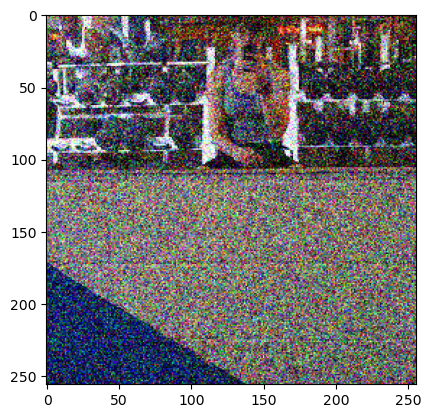

In [11]:
plt.imshow(images_all[1500]), images_all_y[1500]

In [23]:
images_all_y

array([1., 1., 1., ..., 0., 0., 0.])

In [26]:
D = discriminator_v2()
D.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
D.fit(images_all, images_all_y, epochs=30, shuffle=True, batch_size=16)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_28 (Conv2D)          (None, 256, 256, 3)       84        
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_24 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                           

In [27]:
D.predict(images_all[900:1100])

7/7 [==============================] - 1s 36ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.000000

In [30]:
D.save_weights('d_pretrained\discr_v2')

In [33]:
class denoiser_gan(Model):
    
    img_shape = (256, 256, 3)
    
    def __init__(self, generator, discriminator):
        super (denoiser_gan, self).__init__()
        self.G = generator
        self.D = discriminator
        #self.build((None,256,256,3))

        
#    def compile (self, g_optimizer, d_optimizer, loss):
#        super(denoiser_gan, self).compile()
#        self.G.optimizer = g_optimizer
#        self.D.optimizer = d_optimizer
#        self.G.loss = loss
#        self.D.loss = loss
        #self.loss = loss
        

#    def train_step(self, data):
        
#        images_noised, images_clear = data
        
#        images_reconstructed = self.G(images_noised) #, training=True)
        
#        with tf.GradientTape() as tape:
#            fake_out = self.D(images_reconstructed + 0.05 * tf.random.uniform(tf.shape(images_reconstructed)))#, training=True)
#            real_out = self.D(images_clear + 0.05 * tf.random.uniform(tf.shape(images_reconstructed))) #, training=True)
#            d_real_loss = self.D.loss(tf.ones_like(real_out), real_out)
#            d_fake_loss = self.D.loss(tf.zeros_like(fake_out), fake_out)
#            d_loss = d_real_loss + d_fake_loss

#            d_grads = tape.gradient(d_loss, self.D.trainable_variables)
#            self.D.optimizer.apply_gradients(zip(d_grads, self.D.trainable_weights))
            
        #images_reconstructed = self.G(images_noised, training=True)
        
#        with tf.GradientTape() as tape:
#            fake_out = self.D(self.G(images_reconstructed)) # + 0.05 * tf.random.uniform(tf.shape(images_reconstructed)))) #, training=True)
#            g_loss_adv = self.G.loss(tf.ones_like(fake_out), fake_out)
#            g_loss_content = 0 # tf.losses.MeanAbsoluteError()(images_clear, images_reconstructed)
            #g_loss_content = ssim_l2(images_clear, images_reconstructed)
#            g_loss = g_loss_adv # tf.constant([0.9])*g_loss_adv + tf.constant([0.1])*g_loss_content
            
#        g_grads = tape.gradient(g_loss, self.G.trainable_variables)
#        self.G.optimizer.apply_gradients(zip(g_grads, self.G.trainable_weights))

#        ssim = tf.image.ssim(images_clear, images_reconstructed, max_val=1.)
        
#        return {"d_r": d_real_loss, "d_f" :d_fake_loss, "g_adv" :g_loss_adv, "g_cont": g_loss_content, "g_loss": g_loss, "ssim" : ssim}


    @tf.function
    def train_step(self, data):        
        images_noised, images_clear = data

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:

            images_reconstructed = self.G(images_noised, training=True)

            real_out = self.D(images_clear) #  + 0.05 * tf.random.uniform(tf.shape(images_reconstructed)), training=True)
            fake_out = self.D(images_reconstructed) # + 0.05 * tf.random.uniform(tf.shape(images_reconstructed)), training=True)

            d_real_loss = D.loss(tf.ones_like(real_out), real_out)
            d_fake_loss = D.loss(tf.zeros_like(fake_out), fake_out)
            d_loss = d_real_loss + d_fake_loss
                        
            g_loss_adv = G.loss(tf.ones_like(fake_out), fake_out)
            g_loss_content = 0 # tf.losses.MeanAbsoluteError()(images_clear, images_reconstructed)
            #g_loss_content = ssim_l2(images_clear, images_reconstructed)
            g_loss = g_loss_adv # tf.constant([0.9])*g_loss_adv + tf.constant([0.1])*g_loss_content
            
            
        g_grads = g_tape.gradient(g_loss, self.G.trainable_variables)
        d_grads = d_tape.gradient(d_loss, self.D.trainable_variables)
        
        self.G.optimizer.apply_gradients(zip(g_grads, self.G.trainable_variables))
        self.D.optimizer.apply_gradients(zip(d_grads, self.D.trainable_variables))
        
        ssim = tf.image.ssim(images_clear, images_reconstructed, max_val=1.)
        
        #return {"d_r": d_real_loss, "d_f" :d_fake_loss, "g_loss": g_loss, "ssim" : ssim}
        return {"d_r": d_real_loss, "d_f" :d_fake_loss, "g_adv" :g_loss_adv, "g_cont": g_loss_content, "g_loss": g_loss, "ssim" : ssim}

    def train(self, data, epochs):
        h = []
        for epoch in range(epochs):
            for batch in data:
                history = self.train_step(batch)
                h.append(history)
                im_c, im_n = batch
            print (f'epoch {epoch}/{epochs} ssim:{h.ssim}')
        return h
            
        
    
    def call(self, inputs):
        return self.G(inputs)
    
    
    
    def predict(self, inputs):
        return self.G.predict(inputs)
    
    #############################   tf.print()

In [22]:
batch_size = 1
G = generator()
#G.load_weights('dncnn_res_pretrained/dncnn_res')
D = discriminator_v2()
#D.load_weights('d_pretrained\discr_v2')
dngan = denoiser_gan(G, D)
g_opt = Adam(learning_rate=2e-4, beta_1=0.5)
d_opt = Adam(learning_rate=1e-5, beta_1=0.5)
loss = tf.keras.losses.BinaryCrossentropy()

#dngan.summary()

#D.compile(d_opt, loss)
#G.compile(g_opt, loss)
#dngan.compile(Adam(learning_rate=2e-4, beta_1=0.5), loss)
dngan.D.trainable=False
dngan.compile(g_opt, d_opt, loss)
history = dngan.fit(images_noised[:50], images_clear[:50],
                    epochs=200,
                    batch_size=1
                   )


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_122 (Conv2D)            (None, 256, 256, 12  3584        ['input_10[0][0]']               
                                8)                                                                
                                                                                                  
 activation_85 (Activation)     (None, 256, 256, 12  0           ['conv2d_122[0][0]']             
                                8)                                                          

                                                                                                  
 conv2d_129 (Conv2D)            (None, 256, 256, 12  147584      ['add_85[0][0]']                 
                                8)                                                                
                                                                                                  
 batch_normalization_114 (Batch  (None, 256, 256, 12  512        ['conv2d_129[0][0]']             
 Normalization)                 8)                                                                
                                                                                                  
 activation_92 (Activation)     (None, 256, 256, 12  0           ['batch_normalization_114[0][0]']
                                8)                                                                
                                                                                                  
 add_86 (A

                                8)                                'activation_98[0][0]']          
                                                                                                  
 conv2d_136 (Conv2D)            (None, 256, 256, 12  147584      ['add_92[0][0]']                 
                                8)                                                                
                                                                                                  
 batch_normalization_121 (Batch  (None, 256, 256, 12  512        ['conv2d_136[0][0]']             
 Normalization)                 8)                                                                
                                                                                                  
 activation_99 (Activation)     (None, 256, 256, 12  0           ['batch_normalization_121[0][0]']
                                8)                                                                
          

 leaky_re_lu_43 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 16384)             0         
                                                                 
 dense_8 (Dense)             (None, 1024)              16778240  
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 19,884,693
Trainable params: 19,881,877
Non-trainable params: 2,816
_________________________________________________________________
Epoch 1/200


AttributeError: in user code:

    File "C:\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\basil\AppData\Local\Temp\ipykernel_16876\3822866985.py", line 65, in train_step  *
        d_real_loss = D.loss(tf.ones_like(real_out), real_out)

    AttributeError: 'Functional' object has no attribute 'loss'


In [37]:
G = generator()
G.load_weights('dncnn_res_pretrained/dncnn_res')
D = discriminator_v2()
D.load_weights('d_pretrained\discr_v2')
dngan = denoiser_gan(G, D)
G.optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
D.optimizer = Adam(learning_rate=2e-4, beta_1=0.5)
G.loss = tf.keras.losses.BinaryCrossentropy()
D.loss = tf.keras.losses.BinaryCrossentropy()

ds_noised = tf.data.Dataset.from_tensor_slices(images_noised[:100]).batch(1)
ds_clear = tf.data.Dataset.from_tensor_slices(images_clear[:100]).batch(1)
train_data = tf.data.Dataset.zip((ds_noised, ds_clear))

#dngan.train(train_data, epochs=20)
history = dngan.fit(images_noised[:100], images_clear[:100],
                    epochs=200,
                    batch_size=1)
                   

SyntaxError: unexpected EOF while parsing (2196721703.py, line 19)

In [29]:
a=np.array([1])
b=np.array([2])
c=zip(a,b)
c
a1, b1 = c

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
print(dngan.optimizer)
print(dngan.G.optimizer)
print(dngan.D.optimizer)
print(dngan.loss)
print(dngan.G.loss)
print(dngan.D.loss)

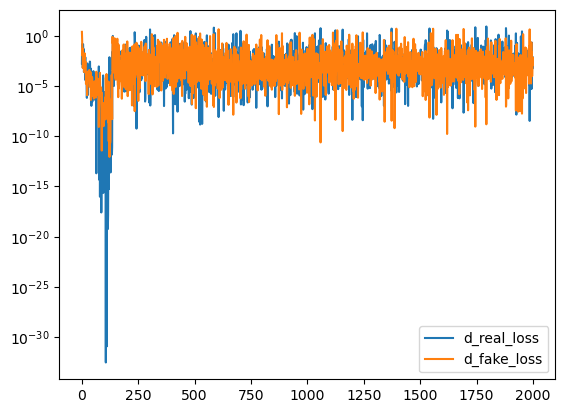

In [18]:
#history = dngan.history
plt.plot(history.history['d_r'], label='d_real_loss')
plt.plot(history.history['d_f'], label='d_fake_loss')
#plt.plot(history.history['g_adv'], label='g_adv_loss')
#plt.plot(history.history['g_loss'], label='g_loss')
plt.yscale('log')
plt.legend()
plt.show()

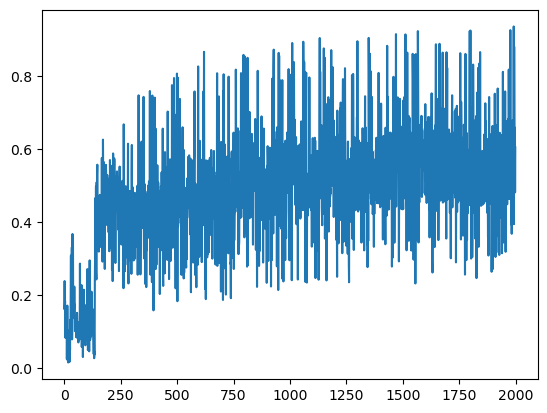

In [19]:
history = dngan.history
plt.plot(history.history['ssim'], label='ssim')

In [35]:
y = predict_all(dngan, images_noised[:20])

1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mean PSNR=6.196482181549072
mean SSIM=0.320011705160141


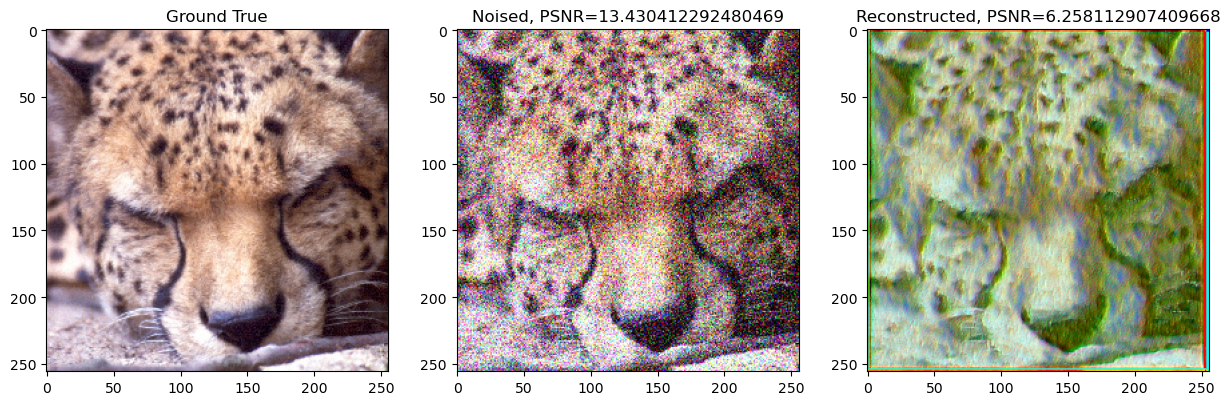

In [36]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear[n],
            images_noised[n],
            y[n],
            max_value=max_value
           )

In [1]:
n=2
plot_result(images_clear[n],
           images_noised[n],
           y[n],
           max_value=1.)

NameError: name 'plot_result' is not defined

In [ ]:
#G.save('gan/G')
#D.save('gan/D')
#dngan.fit(images_noised[:100], images_clear[:100], epochs=1)
dngan.save('gan/dngan')
#dngan.save_weights('gan/dngan_weights')